In [1]:
import pybaseball
import pandas as pd
import numpy as np
import bs4
import requests
import matplotlib.pyplot as plt
import unicodedata
import seaborn as sns
import math
import matplotlib.patches as mpatches
from IPython.display import display
pybaseball.cache.enable()

import os
pd.set_option('display.max_columns',None)
os.getcwd()
os.chdir('C:\\Users\\npacchioli\\Desktop\\pyBaseball\\')
os.getcwd()

directory = 'C:\\Users\\npacchioli\\Desktop\\pyBaseball\\'

from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import statcast_batter
from pybaseball import statcast
from pybaseball import pitching_stats
from pybaseball import cache


In [2]:
#create table to convert months to ranges for bucketing purposes
monthTable22 = pd.DataFrame({'Month': ['2022-04','2022-05','2022-06','2022-07','2022-08','2022-09','2022-10'],
                           'Abbrev': ['Apr','May','Jun','Jul','Aug','Sep','Oct'],
                          'Months': ['Apr-Jun','Apr-Jun','Apr-Jun','Jul-Oct','Jul-Oct','Jul-Oct','Jul-Oct']})

monthTable22

monthTable23 = pd.DataFrame({'Month': ['2023-03','2023-04','2023-05','2023-06','2023-07','2023-08','2023-09', '2023-10'],
                           'Abbrev': ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'],
                          'Months': ['Mar-Jun','Mar-Jun','Mar-Jun','Mar-Jun','Jul-Oct','Jul-Oct','Jul-Oct','Jul-Oct']})

monthTable23

,Month,Abbrev,Months
0,2023-03,Mar,Mar-Jun
1,2023-04,Apr,Mar-Jun
2,2023-05,May,Mar-Jun
3,2023-06,Jun,Mar-Jun
4,2023-07,Jul,Jul-Oct
5,2023-08,Aug,Jul-Oct
6,2023-09,Sep,Jul-Oct
7,2023-10,Oct,Jul-Oct


In [3]:
#get raw data for all pitchers

raw = statcast(start_dt = '2023-03-30',end_dt = '2023-07-19')

This is a large query, it may take a moment to complete


100%|██████████| 112/112 [02:01<00:00,  1.08s/it]


In [4]:
#add the playerID Map
playerID = pd.read_excel('playerMapSavant.xlsx')

In [5]:
raw = raw[raw['zone'].notna()]
raw = raw.sort_values(by=['game_date', 'inning','at_bat_number','pitch_number'], ascending = [True, True,True,True])
raw.groupby(by='zone').mean()

raw['game_date'] = raw['game_date'].astype('|S80')
raw['Month'] = raw['game_date'].str[:7]
raw = pd.merge(raw,monthTable22, how='left', on='Month')

#raw = pd.merge(raw,playerID, how='left', on='batter')

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_9972\3880236066.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  raw.groupby(by='zone').mean()


In [6]:
#create swingStrike and oswing charts

t = []

for i in raw['description']:
    if i == 'swinging_strike' or i == 'swinging_strike_blocked' or i == 'foul_tip':
        j = 1
    else:
        j = 0
        
    t.append(j)
    
#create the pivot wiht swinging strikes
raw['swstr'] = t

#let's get swing

q = []

for i in raw['description']:
    if i == 'foul' or i =='foul_tip' or i == 'foul bunt' or i == 'bunt_foul_tip' or i == 'foul_tip' or i == 'hit_into_play' or i == 'missed_bunt' or i == 'swinging_strike' or i == ' swinging_strike_blocked':
        j = 1
    else:
        j = 0
    
    q.append(j)
    
#let's get location
# if balls it marks as a 1



z = []

for i in raw['zone']:
    if i > 10:
        j=1
    else:
        j=0
        
    z.append(j)

wq = []

for i in raw['description']:
    if i == 'called_strike':
        k = 1
    else:
        k = 0
        
    wq.append(k)
    


raw['called_str'] = wq

raw['csw'] = np.where(raw['swstr'] + raw['called_str'] > 0, 1, 0)
    
    
    
#create balls
raw['ball'] = z

#create swing
raw['swing'] = q

#create chase
raw['chase'] = np.where(raw['swing'] + raw['ball'] == 2, 1,0)
raw

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,Month,Abbrev,Months,swstr,called_str,csw,ball,swing,chase
0,SI,2023-03-30,87.8,-1.9,5.1,"Kluber, Corey",656775,446372,NaN,ball,<NA>,<NA>,<NA>,<NA>,14,Cedric Mullins strikes out swinging.,R,L,R,BOS,BAL,B,<NA>,NaN,0,0,2023,-1.35,0.81,1.13,1.15,<NA>,<NA>,<NA>,0,1,Top,<NA>,<NA>,<NA>,<NA>,624512,<NA>,<NA>,10.172785,-127.391813,-5.120491,-16.823249,26.038103,-22.447777,3.26,1.54,<NA>,<NA>,<NA>,88.1,2077,6.6,718782,446372,624512,671213,624414,646240,571771,807799,594807,657077,53.86,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,Sinker,0,0,0,0,0,0,0,0,Strategic,Standard,222,0.0,0.037,2023-03,NaN,NaN,0,0,0,1,0,0
1,FF,2023-03-30,95.1,-1.84,6.13,"Cole, Gerrit",664774,543037,NaN,ball,<NA>,<NA>,<NA>,<NA>,11,LaMonte Wade Jr. walks.,R,L,R,NYY,SF,B,<NA>,NaN,0,0,2023,-1.04,1.49,-1.25,3.47,<NA>,<NA>,<NA>,0,1,Top,<NA>,<NA>,<NA>,<NA>,624431,<NA>,<NA>,3.832973,-138.307291,-4.5527,-14.180583,33.911708,-12.285625,3.08,1.53,<NA>,<NA>,<NA>,93.7,2326,5.7,718781,543037,624431,519203,518934,518626,683011,665828,592450,519317,54.76,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Strategic,Standard,211,0.0,0.037,2023-03,NaN,NaN,0,0,0,1,0,0
2,SL,2023-03-30,78.7,2.35,6.39,"Corbin, Patrick",660670,571578,NaN,swinging_strike,<NA>,<NA>,<NA>,<NA>,8,Ronald Acuna Jr. singles on a sharp line driv...,R,R,L,WSH,ATL,S,<NA>,NaN,0,0,2023,-0.15,0.16,-0.18,1.65,<NA>,<NA>,<NA>,0,1,Top,<NA>,<NA>,<NA>,<NA>,660688,<NA>,<NA>,-5.271381,-114.557207,-3.77821,-0.277627,21.751904,-30.296881,3.47,1.57,<NA>,<NA>,<NA>,79.6,2149,7.0,718780,571578,660688,642086,671277,600869,682928,669743,645302,657041,53.53,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,Slider,0,0,0,0,0,0,0,0,Standard,Standard,294,0.0,-0.039,2023-03,NaN,NaN,1,0,1,0,1,0
3,FF,2023-03-30,99.6,-1.52,5.65,"deGrom, Jacob",607208,594798,NaN,foul,<NA>,<NA>,<NA>,<NA>,8,Trea Turner strikes out swinging.,R,R,R,TEX,PHI,S,<NA>,NaN,0,0,2023,-0.67,1.31,-0.23,1.57,<NA>,<NA>,<NA>,0,1,Top,<NA>,<NA>,<NA>,<NA>,641680,<NA>,<NA>,5.12128,-144.759737,-8.864845,-10.596388,35.73001,-11.873363,3.33,1.61,2,48.4,-38,99.7,2398,6.5,718779,594798,641680,663993,543760,673962,608369,669701,666969,543257,53.99,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,215,0.0,-0.039,2023-03,NaN,NaN,0,0,0,0,1,0
4,FF,2023-03-30,96.0,2.03,6.68,"Snell, Blake",602074,605483,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,8,Yonathan Daza strikes out swinging.,R,R,L,SD,COL,S,<NA>,NaN,0,0,2023,0.55,1.67,-0.02,2.06,<NA>,<NA>,<NA>,0,1,Top,<NA>,<NA>,<NA>,<NA>,543592,<NA>,<NA>,-6.719798,-139.269876,-10.383589,8.721646,34.383371,-8.234086,3.57,1.65,<NA>,<NA>,<NA>,96.2,2412,6.8,718778,605483,543592,630105,673490,592518,593428,665742,663757,621311,53.68,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,149,0.0,-0.039,2023-03,NaN,NaN,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [7]:
raw = raw[raw['release_spin_rate'].notna()]
raw = raw[raw['spin_axis'].notna()]
raw = raw[raw['release_speed'].notna()]
raw = raw[raw['pfx_x'].notna()]
raw = raw[raw['pfx_z'].notna()]
raw = raw[raw['ax'].notna()]
raw = raw[raw['ay'].notna()]
raw = raw[raw['az'].notna()]
raw = raw[raw['vx0'].notna()]
raw = raw[raw['vy0'].notna()]
raw = raw[raw['vz0'].notna()]
raw = raw[raw['release_extension'].notna()]
raw = raw[raw['zone'].notna()]

raw['pfx_x'] = raw['pfx_x'] * 12
raw['pfx_z'] = raw['pfx_z'] * 12

In [8]:
#get chase rate dataframe
rawBall = raw.loc[raw['ball'] == 1]

#get balls in play data frame
rawBIP = raw.loc[raw['description'] == 'hit_into_play']
rawBIP = rawBIP[rawBIP['launch_speed_angle'].notna()]
rawBIP = rawBIP[rawBIP['launch_speed'].notna()]
rawBIP[['launch_speed','launch_angle']] = rawBIP[['launch_speed','launch_angle']].astype('int64')

# get barrels

b = []

for i in rawBIP['launch_speed_angle']:
    if i == 6:
        j = 1
    else:
        j = 0
        
    b.append(j)
    
    
rawBIP['barrel'] = b

c = []

for i in rawBIP['launch_speed']:
    if i > 94.9:
        j = 1
    else:
        j = 0
        
    c.append(j)
    
rawBIP['hard_hit'] = c

#whiff rate creation

rawSwing = raw.loc[raw['swing'] == 1]

d = []

for i in rawSwing['swstr']:
    if i == 1:
        j = 1
    else:
        j = 0
    
    d.append(j)
    
rawSwing['whiff'] = d



C:\Users\npacchioli\AppData\Local\Temp\ipykernel_9972\2222217273.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rawSwing['whiff'] = d


In [12]:
choose_player = 'Fujinami, Shintaro'

In [13]:
#swstr DF
swstr_df = raw.loc[raw['player_name'] == choose_player]
swstr_df['pitchNumber'] = range(len(swstr_df))
swstr_df['rolling_swstr'] = swstr_df['swstr'].rolling(100).mean()
swstr_df = swstr_df.reset_index()

#chase rate DF
chase_df = rawBall.loc[rawBall['player_name'] == choose_player]
chase_df['pitchNumber'] = range(len(chase_df))
chase_df['rolling_swstr'] = chase_df['chase'].rolling(100).mean()

#barrel rate DF
barrel_df = rawBIP.loc[rawBIP['player_name'] == choose_player]
barrel_df['pitchNumber'] = range(len(barrel_df))
barrel_df['barrel_rate'] = barrel_df['barrel'].rolling(20).mean()

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_9972\3714944194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swstr_df['pitchNumber'] = range(len(swstr_df))
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_9972\3714944194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swstr_df['rolling_swstr'] = swstr_df['swstr'].rolling(100).mean()
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_9972\3714944194.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

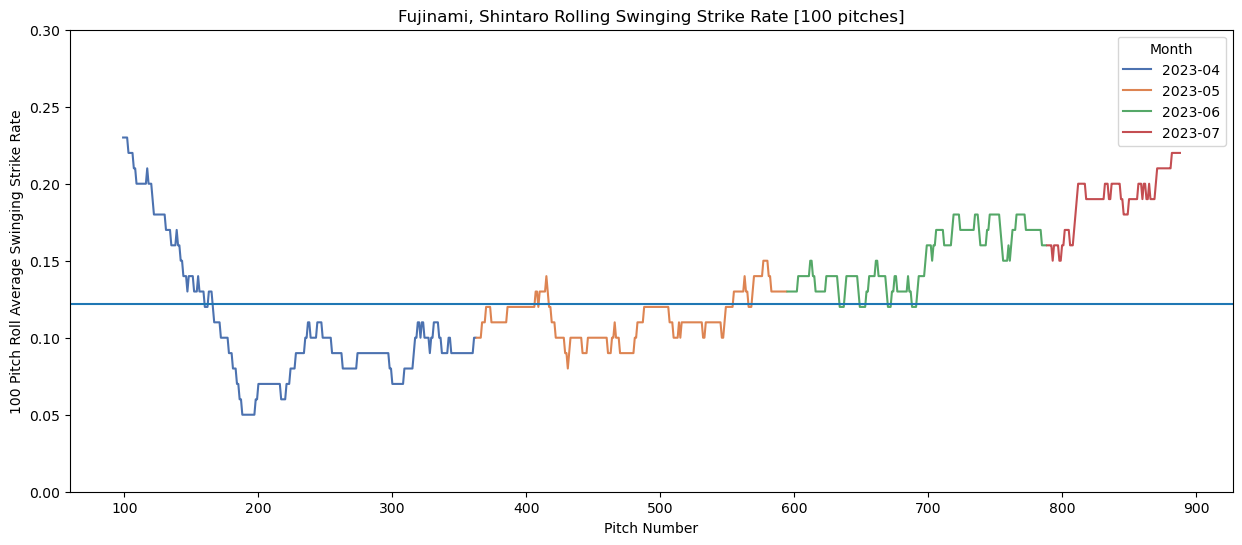

In [14]:
plt.figure(figsize = (15,6))

sns.lineplot(data = swstr_df, x = 'pitchNumber', y = 'rolling_swstr', hue = 'Month', palette = 'deep').set(ylim=(0,.30))
plt.xlabel('Pitch Number')
plt.ylabel('100 Pitch Roll Average Swinging Strike Rate')
plt.title(choose_player + ' Rolling Swinging Strike Rate [100 pitches]')
plt.axhline(.122)
#plt.text(300,.11,"League Average: 12.2%")

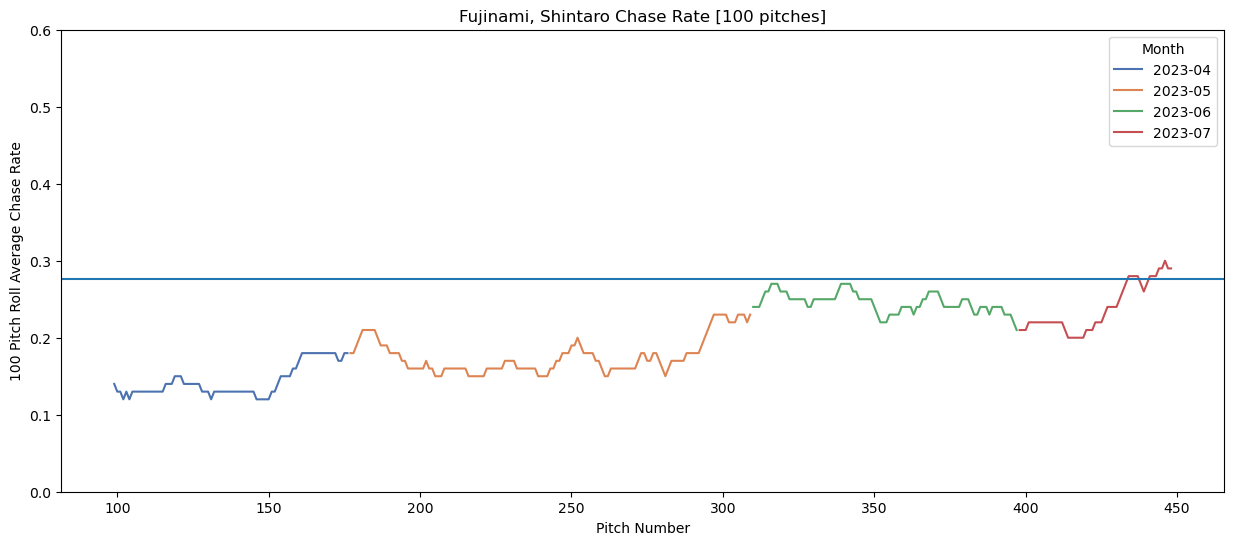

In [15]:
plt.figure(figsize = (15,6))

sns.lineplot(data = chase_df, x = 'pitchNumber', y = 'rolling_swstr', hue = 'Month', palette = 'deep').set(ylim=(0,.60))
plt.xlabel('Pitch Number')
plt.ylabel('100 Pitch Roll Average Chase Rate')
plt.title(choose_player + ' Chase Rate [100 pitches]')
plt.axhline(.276)
#plt.text(230,.255,"League Average: 27.6%")

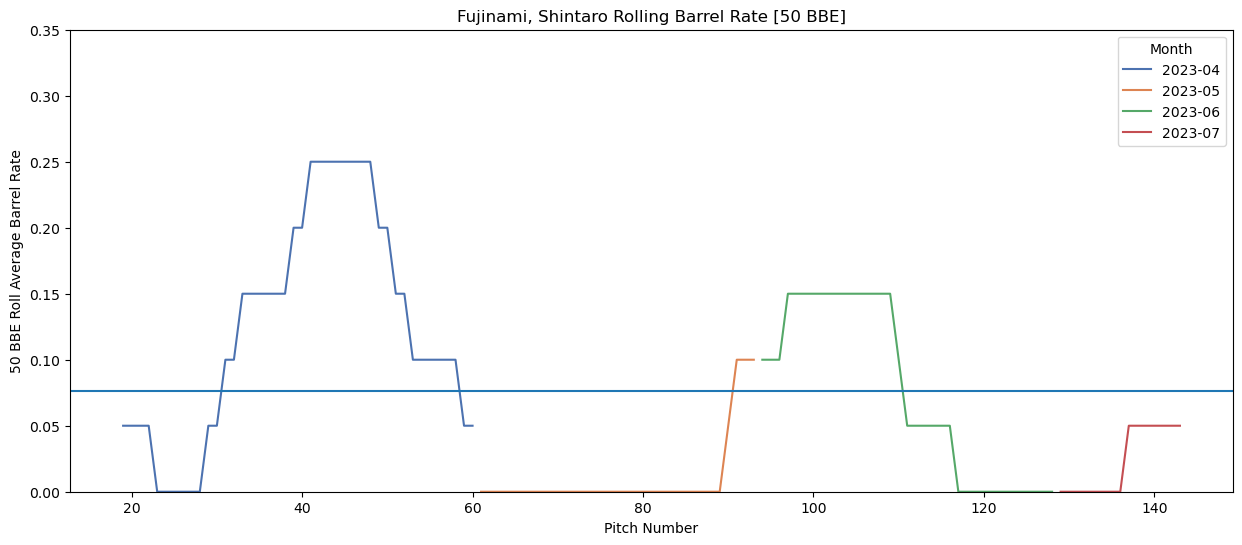

In [16]:
plt.figure(figsize = (15,6))

sns.lineplot(data = barrel_df, x = 'pitchNumber', y = 'barrel_rate', hue = 'Month', palette = 'deep').set(ylim=(0,.35))
plt.xlabel('Pitch Number')
plt.ylabel('50 BBE Roll Average Barrel Rate')
plt.title(choose_player + ' Rolling Barrel Rate [50 BBE]')
plt.axhline(.076)
#plt.text(50,.06,"League Average: 7.5%")

In [17]:
#pivots for master table

#pitches seen
raw['pitches_thrown'] = raw.groupby('player_name')['player_name'].transform('size')
pitches_seen = raw.groupby(by='player_name').count()
pitches_seen = pitches_seen.reset_index()
pitches_seen = pitches_seen[['player_name','pitch_type']]
pitches_seen

#chase
chasepiv = pd.pivot_table(rawBall,index ='player_name', values = 'chase')
chasepiv = chasepiv.reset_index()
chasepiv

#barrel
barrelpiv = pd.pivot_table(rawBIP,index ='player_name', values = ('barrel','launch_speed','launch_angle','hard_hit'))
barrelpiv = barrelpiv.reset_index()
barrelpiv

#whiff leaderboard
whiffpiv = pd.pivot_table(rawSwing, index = 'player_name', values = 'whiff')
whiffpiv = whiffpiv.reset_index()
whiffpiv

#csw
cswpiv = pd.pivot_table(raw, index = 'player_name', values = 'csw')
cswpiv = cswpiv.reset_index()

#swinging strike leaderboard
leaderboard = pd.pivot_table(raw,index = 'player_name',values = ('swstr'))
leaderboard = leaderboard.reset_index()
leaderboard = pd.merge(leaderboard, pitches_seen, on = 'player_name', how = 'left')

#get 90th percentile EV
def ev_90th(g):
    return np.percentile(g,90)

ev90 = pd.pivot_table(rawBIP,index='player_name',values = 'launch_speed',aggfunc = [ev_90th])
ev90 = ev90.reset_index()

#add chases
leaderboard = pd.merge(leaderboard, chasepiv, on = 'player_name', how = 'left')
leaderboard = leaderboard.reset_index()
leaderboard = leaderboard.sort_values(by='chase',ascending = True)
leaderboard = leaderboard.drop(['index'], axis = 1)

#add barrels and hit damage
leaderboard = pd.merge(leaderboard, barrelpiv, on = 'player_name', how = 'left')
leaderboard = leaderboard.reset_index()
leaderboard = leaderboard.drop(['index'], axis = 1)

#add whiffs
leaderboard = pd.merge(leaderboard, whiffpiv, on = 'player_name', how = 'left')
leaderboard = leaderboard.reset_index()
leaderboard = leaderboard.drop(['index'], axis = 1)

#add csw
leaderboard = pd.merge(leaderboard, cswpiv, on = 'player_name', how = 'left')

#add EV90
leaderboard = pd.merge(leaderboard,ev90, on = 'player_name', how = 'left')

#filter by pitches seen
pseen = 1
leaderboard = leaderboard.loc[leaderboard['pitch_type'] > pseen]

#try rename
leaderboard = leaderboard.rename(columns = {'pitch_type':'pitches_thrown', '(\'ev_90th\', \'launch_speed\')': 'ev90'})

#sort
leaderboard = leaderboard.sort_values(by= 'launch_angle',ascending = True)

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_9972\3676402108.py:61: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  leaderboard = pd.merge(leaderboard,ev90, on = 'player_name', how = 'left')
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_9972\3676402108.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  leaderboard = pd.merge(leaderboard,ev90, on = 'player_name', how = 'left')


In [16]:
leaderboard.loc[leaderboard['pitches_thrown'] > 200].head(50)

,player_name,swstr,pitches_thrown,chase,barrel,hard_hit,launch_angle,launch_speed,whiff,csw,"(ev_90th, launch_speed)"
114,"Pallante, Andre",0.093863,554,0.210714,0.054348,0.402174,-10.108696,87.347826,0.210970,0.256318,104.0
594,"Cano, Yennier",0.117550,604,0.304196,0.042373,0.372881,-4.271186,87.186441,0.231788,0.289735,104.3
575,"Alexander, Scott",0.111111,333,0.299363,0.060241,0.361446,-3.819277,88.445783,0.202247,0.240240,105.0
463,"King, John",0.086466,266,0.278689,0.044776,0.432836,-3.641791,86.910448,0.166667,0.270677,101.0
433,"Duran, Jhoan",0.185811,592,0.273973,0.083333,0.369048,-3.559524,85.785714,0.325581,0.309122,105.0
65,"Romero, JoJo",0.152542,236,0.188034,0.027778,0.361111,-2.888889,86.305556,0.378947,0.334746,104.0
682,"Saucedo, Tayler",0.149398,415,0.333333,0.056338,0.281690,-2.239437,83.774648,0.326087,0.330120,102.0
548,"Peralta, Wandy",0.132653,588,0.294118,0.051020,0.357143,-1.448980,84.938776,0.285171,0.255102,104.0
165,"Toussaint, Touki",0.105386,427,0.228571,0.050000,0.316667,-1.416667,84.916667,0.248521,0.276347,102.0
359,"Bummer, Aaron",0.115587,571,0.264085,0.011765,0.494118,-1.094118,89.729412,0.251064,0.323993,104.0


In [30]:
name_check = 'Fujinami, Shintaro'
leaderboard.loc[leaderboard['player_name'] == name_check]

,player_name,swstr,pitches_thrown,chase,barrel,hard_hit,launch_angle,launch_speed,whiff,csw,"(ev_90th, launch_speed)"
98,"Fujinami, Shintaro",0.139483,889,0.2049,0.069444,0.458333,15.493056,91.298611,0.310433,0.283465,105.0


In [31]:
nameC = raw.loc[raw['player_name'] == name_check]

xx = pd.pivot_table(nameC, index = 'pitch_type', values = ('release_pos_z','pfx_x','pfx_z', 'release_speed',
                                                           'spin_axis','release_spin_rate','swstr','csw') )
xx = xx.reset_index()
xx

yy = pd.pivot_table(nameC, index = 'pitch_type',values = 'description', aggfunc = 'count')
yy = yy.reset_index()
yy

xx = pd.merge(xx,yy, on = 'pitch_type', how = 'left')
xx

,pitch_type,csw,pfx_x,pfx_z,release_pos_z,release_speed,release_spin_rate,spin_axis,swstr,description
0,CU,0.000000,9.96,-8.52,5.69,75.7,2152.0,13.0,0.000000,1
1,FC,0.340136,0.947755,2.590204,5.457823,87.933333,2006.666667,131.537415,0.163265,147
2,FF,0.283133,-11.065542,13.840964,5.482751,98.032731,1954.905622,223.97992,0.114458,498
3,FS,0.210227,-10.167273,3.276136,5.649148,92.557386,1165.840909,241.454545,0.187500,176
4,SI,0.600000,-16.2,11.832,5.438,97.26,1810.0,225.4,0.200000,5
5,SL,0.411765,1.983529,-3.169412,5.502353,84.594118,2058.588235,58.235294,0.117647,17
6,ST,0.311111,10.469333,3.064,5.376,84.122222,2133.644444,59.0,0.155556,45


In [38]:
#to excel if necessary

os.chdir('C:\\Users\\npacchioli\\Desktop\\pyBaseball\\2023\\')
os.getcwd()

directory = 'C:\\Users\\npacchioli\\Desktop\\pyBaseball\\2023\\'

leaderboard.to_excel(directory + 'pitch_leaders2023.xlsx')